Автор: Лейман М.А.   
Дата создания: 22.03.2025  

# Задание ZALA  
## 4. Детектирование множества объектов
### Модель __YOLO11s__ 

## Импорты

In [16]:
import time
from glob import glob
import os 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
import torch
from matplotlib import rcParams
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = (14,6)


print('Виртуальное окружение')
!which python 
# Текущее положение
print('\nТекущее положение: ')
path_1 = os.getcwd()
print(path_1)

Виртуальное окружение
/home/maksim/anaconda3/envs/rapids-25.02/bin/python

Текущее положение: 
/home/maksim/develops/python/devsTraining/zala_task


## Проверка GPU

In [17]:
# устанавливаем device если gpu или cpu

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("работаем на устройстве: ", device)
print('Версия torch:           ', torch.__version__)
print("версия  cuDNN:          ", torch.backends.cudnn.version())

# ПРОВЕРКА GPU
!nvidia-smi

работаем на устройстве:  cuda
Версия torch:            2.6.0+cu124
версия  cuDNN:           90100
Fri Apr 18 11:48:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:01:00.0  On |                  N/A |
|  0%   56C    P8             20W /  170W |    1548MiB /  12288MiB |     37%      Default |
|                                         

In [18]:
# Получаем текущую директорию
path_dir = os.getcwd()
print("Текущая директория:", path_dir)

DATA_DIR = os.path.abspath(os.path.join(path_dir, 'dataset'))
print("Путь к dataset:", DATA_DIR)


Текущая директория: /home/maksim/develops/python/devsTraining/zala_task
Путь к dataset: /home/maksim/develops/python/devsTraining/zala_task/dataset


## Обучение

### Yolo

In [19]:
from glob import glob
import os
import numpy as np
from IPython.display import clear_output
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from tqdm import tqdm_notebook
import torch.nn.functional as F
from torchvision import models

import time
from matplotlib import rcParams
import torch

# np.random.seed(42)
#set_global_seed(42)

In [ ]:
from ultralytics import YOLO
import torch
from thop import profile

# model = YOLO("models/yolo11s.pt")
# model = YOLO("models/yolov8s.pt")  
model = YOLO("models/11s_best_UAVOD5.pt")


# Создаем фейковый вход с размером изображения
dummy_input = torch.randn(1, 3, 1024, 1024).to(model.device) 

# Профилируем модель
flops, params = profile(model.model, inputs=(dummy_input,))

# Выводим GFLOPs и количество параметров
print(f"GFLOPs: {flops / 1e9:.2f}")
print(f"Params: {params / 1e6:.2f}M")

model.info()

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.Upsample'>.
GFLOPs: 27.62
Params: 9.43M
YOLO11s summary: 181 layers, 9,432,823 parameters, 0 gradients, 21.6 GFLOPs


(181, 9432823, 0, 21.574297599999998)

In [ ]:
# ['auto', 'Adam', 'SGD', 'AdamW', 'Adamax', 'NAdam', 'RAdam']

model.half();

torch.cuda.empty_cache()

for opt in ['AdamW']:
    for mosaic in [1.0]:
        for lr00 in [0.0001]:
            for iou0 in [0.5]:
                for batch in [8]:
                    # Очистка экрана перед каждой новой тренировкой
                    os.system('cls' if os.name == 'nt' else 'clear')  # Для терминала
                    clear_output(wait=True)  

                    print(f"Запуск тренировки: opt={opt}, batch={batch}, mosaic={mosaic}, lr0={lr00}, iou={iou0}")
                    
                    model.train(
                        data="data_1.yaml",
                        epochs=25,
                        imgsz=736,
                        batch=batch,
                        device="cuda",
                        lr0=lr00,
                        lrf=0.01,
                        cos_lr=True,
                        momentum=0.951,
                        weight_decay=0.01,
                        optimizer=opt,
                        cache=None,
                        max_det=290,            # максимальное количество детектируемых объектов        
                        single_cls=False,
                        patience=20,
                        verbose=True,
                        dropout=0.2,
                        freeze=0,
                        iou=iou0,  
                        half=True,          # 16-битная (FP16) арифметика
                        workers=0,
                        mosaic=mosaic,
                        close_mosaic=10,
                        multi_scale=False,  # разные размеры
                        mixup=0.2,         # Смешивание изображений в одно
                        copy_paste=0.1,    # Вставка объекта с другого изображения    
                        scale=0.1,             
                        val=True,
                        plots=True,
                        amp= True,         # Смешанная точность
                        fraction=1.0,      # используемая доля обучающих данных
                  
                    )

                    time.sleep(1) 


Запуск тренировки: opt=AdamW, batch=8, mosaic=1.0, lr0=0.0001, iou=0.5
New https://pypi.org/project/ultralytics/8.3.111 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.95 🚀 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12029MiB)
engine/trainer: task=detect, mode=train, model=models/11s_best_UAVOD5.pt, data=data_1.yaml, epochs=25, time=None, patience=20, batch=8, imgsz=736, save=True, save_period=-1, cache=None, device=cuda, workers=0, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=0, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.5, max_det=290, half=True, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_n

train: Scanning /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/dataset_full/labels/train.cache... 16606 images, 248 backgrounds, 2 corrupt: 100%|██████████| 16606/16606 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/dataset_full/images/train/P0020_crop132.jpg: ignoring corrupt image/label: Label class 80 exceeds dataset class count 13. Possible class labels are 0-12
train: WARNING ⚠️ /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/dataset_full/images/train/P0020_crop192.jpg: ignoring corrupt image/label: Label class 80 exceeds dataset class count 13. Possible class labels are 0-12



val: Scanning /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/dataset_full/labels/val.cache... 950 images, 6 backgrounds, 0 corrupt: 100%|██████████| 950/950 [00:00<?, ?it/s]

Plotting labels to runs/detect/train7/labels.jpg... 


optimizer: AdamW(lr=0.0001, momentum=0.951) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.01), 87 bias(decay=0.0)
Image sizes 736 train, 736 val
Using 0 dataloader workers
Logging results to runs/detect/train7
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      9.57G     0.8748     0.5531     0.9271        111        736: 100%|██████████| 2076/2076 [10:11<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.08it/s]


                   all        950      21796       0.74      0.668      0.695      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      10.6G     0.8096     0.5008     0.9078         69        736: 100%|██████████| 2076/2076 [10:07<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.13it/s]

                   all        950      21796      0.824      0.727      0.752       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      9.48G     0.7745     0.4763     0.8991         82        736: 100%|██████████| 2076/2076 [10:01<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.19it/s]

                   all        950      21796      0.846       0.73      0.768      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25       9.5G     0.7551     0.4603     0.8929         94        736: 100%|██████████| 2076/2076 [09:59<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.20it/s]

                   all        950      21796      0.811      0.741       0.77      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      9.54G     0.7572     0.4624     0.8932        120        736: 100%|██████████| 2076/2076 [10:14<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.20it/s]

                   all        950      21796      0.839      0.724      0.766      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      9.54G     0.7479     0.4562     0.8911        159        736: 100%|██████████| 2076/2076 [10:45<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:16<00:00,  3.64it/s]

                   all        950      21796      0.817       0.73       0.76      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      9.58G     0.7424     0.4526     0.8902        121        736: 100%|██████████| 2076/2076 [09:50<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:13<00:00,  4.39it/s]

                   all        950      21796       0.85      0.719      0.762       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      9.58G     0.7423     0.4529     0.8898         49        736: 100%|██████████| 2076/2076 [09:42<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.18it/s]

                   all        950      21796      0.826      0.719      0.757      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      8.01G     0.7338     0.4484     0.8878        155        736: 100%|██████████| 2076/2076 [10:03<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:17<00:00,  3.36it/s]


                   all        950      21796      0.807      0.723      0.748      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      8.03G     0.7368     0.4491     0.8877        113        736: 100%|██████████| 2076/2076 [10:26<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.20it/s]

                   all        950      21796      0.816      0.731      0.754      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      8.04G     0.7377     0.4504     0.8889        208        736: 100%|██████████| 2076/2076 [10:00<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.19it/s]

                   all        950      21796      0.787      0.739      0.757      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      8.04G     0.7323     0.4477      0.888        162        736: 100%|██████████| 2076/2076 [10:00<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.21it/s]

                   all        950      21796      0.833      0.724      0.763      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      8.05G     0.7329     0.4466     0.8873         35        736: 100%|██████████| 2076/2076 [10:01<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.19it/s]

                   all        950      21796      0.824      0.733      0.759      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      8.07G     0.7369     0.4487     0.8877        179        736: 100%|██████████| 2076/2076 [09:58<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.17it/s]

                   all        950      21796      0.827      0.727      0.757      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      8.08G     0.7279     0.4447     0.8865        227        736: 100%|██████████| 2076/2076 [10:01<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.22it/s]

                   all        950      21796      0.807      0.704      0.748      0.449


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      8.08G     0.5472     0.3153     0.8209         74        736: 100%|██████████| 2076/2076 [08:47<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.21it/s]

                   all        950      21796      0.818      0.723      0.759      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      8.08G     0.5412      0.311      0.819        253        736: 100%|██████████| 2076/2076 [08:49<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.11it/s]

                   all        950      21796      0.835      0.716      0.766      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      8.08G     0.5366     0.3087     0.8186         51        736: 100%|██████████| 2076/2076 [08:47<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.17it/s]

                   all        950      21796      0.842      0.706      0.763      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      8.08G     0.5322     0.3062     0.8178         44        736: 100%|██████████| 2076/2076 [08:47<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.20it/s]

                   all        950      21796      0.803      0.735      0.759      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      8.08G     0.5316     0.3058     0.8174        115        736: 100%|██████████| 2076/2076 [08:47<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.18it/s]

                   all        950      21796      0.828      0.719      0.763      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      8.08G      0.529     0.3044     0.8175        139        736: 100%|██████████| 2076/2076 [08:46<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.19it/s]

                   all        950      21796      0.822      0.711      0.757      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      8.08G     0.5304     0.3056     0.8174         74        736: 100%|██████████| 2076/2076 [08:46<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.21it/s]

                   all        950      21796      0.816      0.715      0.759      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      8.12G     0.5299     0.3044      0.817         53        736: 100%|██████████| 2076/2076 [08:49<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.13it/s]

                   all        950      21796       0.83      0.711      0.763      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      8.12G     0.5284     0.3043     0.8168        188        736: 100%|██████████| 2076/2076 [08:47<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.21it/s]

                   all        950      21796      0.825      0.716      0.763      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      8.12G      0.527     0.3038     0.8168         30        736: 100%|██████████| 2076/2076 [08:48<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:14<00:00,  4.15it/s]

                   all        950      21796      0.815      0.721       0.76      0.465



25 epochs completed in 4.093 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 19.2MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics 8.3.95 🚀 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12029MiB)
YOLO11s summary (fused): 100 layers, 9,417,831 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:15<00:00,  3.94it/s]


                   all        950      21796      0.809      0.723      0.762      0.467
              building        681      13500      0.873      0.849      0.894      0.597
              fish net        148       1051      0.862      0.858      0.821      0.633
             landslide         16         25      0.558       0.68      0.602      0.364
                  pool         53         77      0.793      0.792      0.812      0.457
                 house        550       2719      0.856      0.818      0.868      0.545
                quarry        136        147      0.927      0.721      0.817      0.634
                  ship        283       1674      0.663      0.543      0.619      0.321
               vehicle        373       1350      0.818       0.38      0.523      0.203
                  well        397       1253      0.927      0.869      0.904      0.445
Speed: 0.2ms preprocess, 4.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect

## Первая итерация обучения 
### На начальном датасете  __UAVOD__  844 изображения.

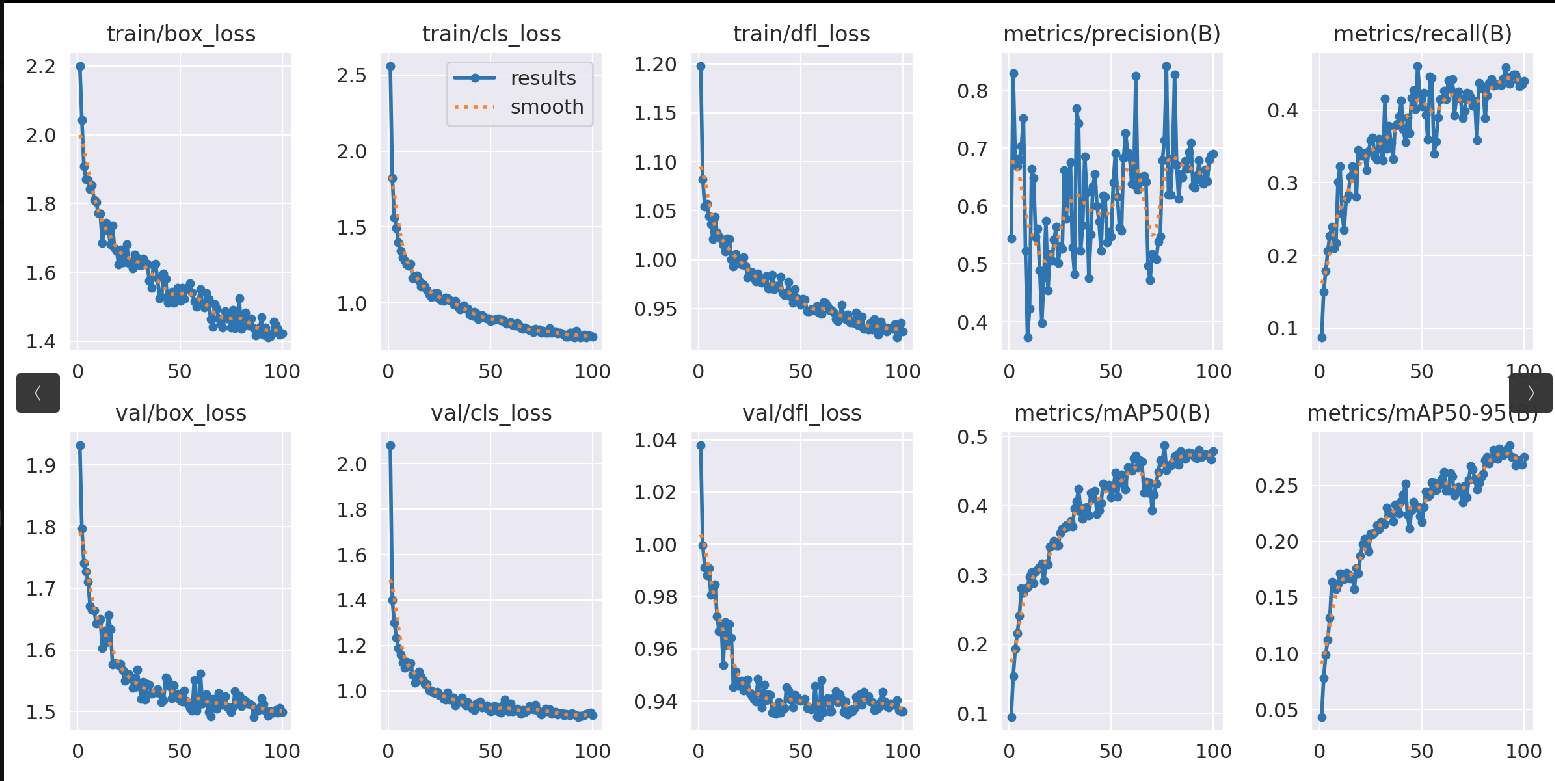

### На увеличенном датасете  __UAVOD__  12000 изображений.  
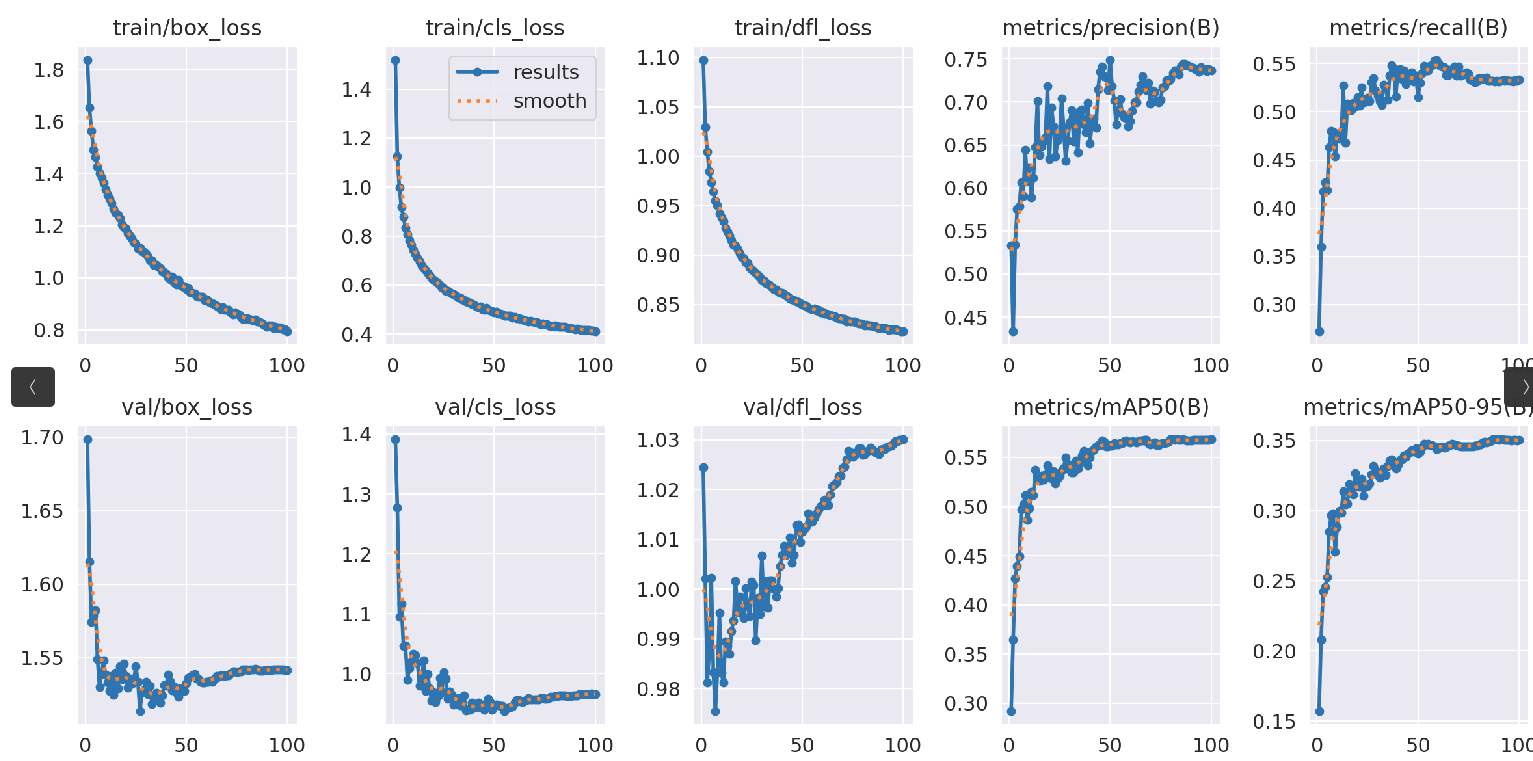


In [24]:
def metrics_model(model, split="test", iou=0.5):
    metrics = model.val(data="data_1.yaml", split=split, iou=iou)
    precision = metrics.box.p.mean().item()    # Precision
    recall = metrics.box.r.mean().item()       # Recall
    map50 = metrics.box.map50.mean().item()    # AP50 (IoU=0.5)
    map50_95 = metrics.box.maps.mean().item()  # mAP50-95

    print("\n=== Итоговые метрики по тестовому набору ===")
    print(f"Средняя точность (Precision): {precision:.3f}")
    print(f"Средняя полнота (Recall): {recall:.3f}")
    print(f"Средняя AP50 (IoU={iou:.2f}): {map50:.3f}")
    print(f"Средний mAP50-95: {map50_95:.3f}")


In [25]:
metrics_model(model, split="test", iou=0.5)

Ultralytics 8.3.95 🚀 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12029MiB)
YOLO11s summary (fused): 100 layers, 9,417,831 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_UAVOD/dataset_full/labels/test.cache... 719 images, 7 backgrounds, 0 corrupt: 100%|██████████| 719/719 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 90/90 [00:11<00:00,  7.64it/s]


                   all        719      13735      0.866      0.741      0.815      0.504
              building        482       8852      0.816      0.789      0.796      0.495
              fish net        104        426      0.924       0.91      0.935      0.738
             landslide         18         19      0.735      0.737      0.743      0.532
                  pool         30         41      0.971      0.805      0.918       0.52
                 house        355       1824      0.843       0.87      0.881      0.566
                quarry         68         98      0.981      0.515      0.833      0.474
                  ship        207        911      0.897      0.858      0.883      0.473
               vehicle        233        607      0.756      0.386        0.5      0.254
                  well        325        957      0.873        0.8      0.845      0.482
Speed: 0.2ms preprocess, 4.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect

### Итоги обучения. Метрики на тестовом наборе.



====== Итоговые метрики по тестовому набору UAVOD __начальный dataset__ ===    100 Эпох.  модель 0  
Средняя точность (Precision): 0.537  
Средняя полнота (Recall): 0.356  
Средняя AP50 (IoU=0.50): 0.391  
Средний mAP50-95: 0.203  


====== Итоговые метрики по тестовому набору UAVOD __full_dataset__ ===    100 Эпох.   модель 1  
Средняя точность (Precision): 0.673  
Средняя полнота (Recall): 0.507  
Средняя AP50 (IoU=0.50): 0.530  
Средний mAP50-95: 0.300  

### Продолжение обучения  


====== Итоговые метрики по тестовому набору UAVOD __full_dataset__ ===   модель 2  

 5 Эпох.   После применения __mixup__  и  __copy_paste__  

Средняя точность (Precision): 0.691  
Средняя полнота (Recall): 0.596  
Средняя AP50 (IoU=0.50): 0.627  
Средний mAP50-95: 0.365  


====== Итоговые метрики по тестовому набору UAVOD __full_dataset__ ===    

5 Эпох.   После применения __mixup__  и  __copy_paste__  размер изображений (640)  

Средняя точность (Precision): 0.775  
Средняя полнота (Recall): 0.614  
Средняя AP50 (IoU=0.50): 0.673  
Средний mAP50-95: 0.401  


====== Итоговые метрики по тестовому набору UAVOD __full_dataset__ ===     модель  3  

15 Эпох.   После применения __mixup__  и  __copy_paste__  размер изображений (640)  фиксированный     

Средняя точность (Precision): 0.818  
Средняя полнота (Recall): 0.624  
Средняя AP50 (IoU=0.50): 0.691  
Средний mAP50-95: 0.435  



====== Итоговые метрики по тестовому набору  ===  4 модель   

размер изображений (736)  фиксированный  + добавлены изображения с датасета __DOTA__   

Средняя точность (Precision): 0.907  
Средняя полнота (Recall): 0.734  
Средняя AP50 (IoU=0.50): 0.812  
Средний mAP50-95: 0.564  






In [10]:
metrics_model(model, split="test", iou=0.5)

Ultralytics 8.3.95 🚀 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12029MiB)
YOLO11s summary (fused): 100 layers, 9,418,992 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset2/dataset_full2/labels/test.cache... 187 images, 0 backgrounds, 0 corrupt: 100%|██████████| 187/187 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.73it/s]


                   all        187      27649      0.691      0.349      0.382      0.223
                 plane         29       1461      0.806      0.554      0.594      0.291
                  ship         53       2489      0.777       0.45      0.509      0.227
          storage-tank         23        142      0.773      0.192      0.226      0.136
      baseball-diamond         21         71      0.875      0.465      0.516      0.301
          tennis-court         45        386      0.913      0.821      0.856      0.718
      basketball-court         14         52      0.774      0.385      0.509      0.339
    ground-track-field         28         53      0.676      0.355      0.358      0.226
                harbor         45        610      0.724      0.661      0.705      0.327
                bridge         25        163      0.465     0.0481     0.0512      0.019
         large-vehicle         68       2911       0.69      0.482      0.516      0.326
         small-vehicl

In [24]:
import torch
from ultralytics import YOLO
from thop import profile
# model = YOLO("models/yolo11s.pt")
# model = YOLO("models/yolov8s.pt")  
model = YOLO("models/11s_best_UAVOD4.pt")

model.info()

YOLO11s summary: 181 layers, 9,431,662 parameters, 0 gradients, 21.6 GFLOPs


(181, 9431662, 0, 21.567846399999997)

In [ ]:
import torch
from ultralytics import YOLO
from thop import profile

# Загружаем YOLO-модель 
model = YOLO("models/11s_best_UAVOD4.pt").model

# Создаем входные тензоры разного размера
dummy_640 = torch.randn(1, 3, 640, 640)
dummy_1024 = torch.randn(1, 3, 1024, 1024)

# Вычисляем FLOPs и параметры для 640x640
flops_640, params_640 = profile(model, inputs=(dummy_640,), verbose=False)

# Вычисляем FLOPs и параметры для 1024x1024
flops_1024, params_1024 = profile(model, inputs=(dummy_1024,), verbose=False)

# Возвращаем данные в GFLOPs и миллионах параметров
{
    "640x640": {
        "GFLOPs": flops_640 / 1e9,
        "Params (M)": params_640 / 1e6
    },
    "1024x1024": {
        "GFLOPs": flops_1024 / 1e9,
        "Params (M)": params_1024 / 1e6
    }
}



{'640x640': {'GFLOPs': 10.7839232, 'Params (M)': 9.431662},
 '1024x1024': {'GFLOPs': 27.606843392, 'Params (M)': 9.431662}}